# COVID DATA ANALYSIS

## 1. INTRODUCTION

With this project, we analyze data concerning the covid-19 pandemic and world countries. Our purpose is to find relations between confirmed cases, deaths, vaccines, flights, and country features, such as population and area.

### 1.1. LIBRARIES AND FUNCTIONS

First, we import all the libraries and define the functions we need for this project.

In [1]:
#we import all libraries
import os # needed to interact with the operating system (e.g. save/load a database)
import numpy as np # numerical library (linear algebra)
import pandas as pd # table manipulation. Based on numpy
from matplotlib import pyplot as plt # plots
import seaborn as sns # based on matplotlib. Very powerful plot library
import sqlite3 # needed to write SQL code in our notebooks and convert the results into Python tables. 

try:
    os.remove("database.db")
except OSError:
    pass

# the following stuff simplifies the interaction with SQL
conn = sqlite3.connect("database.db")
cur = conn.cursor()

def run_sql(sql_command): # executes a SQL code
  cur.execute(sql_command)
  conn.commit()
  if cur.description != None:
    col_names = [i[0] for i in cur.description]
    result = pd.DataFrame(cur.fetchall(), columns = col_names)
    result
    return result

def dataframe_to_table(df,table_name): # converts a dataframe into a SQL table in our database.
  df.to_sql(table_name, conn, if_exists='replace', index = False)
  conn.commit()

### 1.2. IMPORT DATA

We find the data we need in the following files:
- https://github.com/datasets/covid-19/blob/main/data/countries-aggregated.csv
- https://developers.google.com/public-data/docs/canonical/countries_csv
- https://www.kaggle.com/tanuprabhu/population-by-country-2020?select=population_by_country_2020.csv
- https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/vaccinations.csv
- https://raw.githubusercontent.com/ActiveConclusion/COVID19_AirTraffic/master/flight_data/flights.csv

Then, we open them as pandas dataframes.

In [2]:
df_covid = pd.read_csv(r"C:\Users\leona\OneDrive\Desktop\Report\covid.csv")
df_countries = pd.read_csv(r"C:\Users\leona\OneDrive\Desktop\Report\countries.csv")
df_flights = pd.read_csv(r"C:\Users\leona\OneDrive\Desktop\Report\flights.csv")
df_population = pd.read_csv(r"C:\Users\leona\OneDrive\Desktop\Report\population.csv")
df_vaccinations = pd.read_csv(r"C:\Users\leona\OneDrive\Desktop\Report\vaccinations.csv")

Finally, we convert the dataframes in temporary SQL databases.

In [3]:
dataframe_to_table(df_vaccinations,"vaccinations_tmp")
dataframe_to_table(df_population,"population_tmp")
dataframe_to_table(df_flights,"flights_tmp") 
dataframe_to_table(df_countries,"countries_tmp")
dataframe_to_table(df_covid,"covid_tmp")

C:\Users\leona\anaconda3\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


## 2. DATABASE

### 2.1. SPECIFICATION

We store world countries. We record a unique identifier, the name, the population, the land area (in Km2), and the coordinates (latitude and longitude) for each country. Then, we record the cumulative covid cases, the cumulative recovered patient, and the cumulative deaths for each country and each specific day. Moreover, we store the vaccine records for a specific country on each given day; we register the cumulative number of vaccines, the cumulative people vaccinated, and the daily vaccinations. Finally, we track the domestic flights, the international departures, the international arrivals, and total flights for each country and day. 

### 2.2. LOGICAL DESIGN

- **Country**(<u>identifier</u>, name, population, land_area, latitude, longitude)
- **Covid_cases**(<u>country_code</u>: fk to country(identifier), <u>day</u>, confirmed, recovered, deaths)
- **Vaccines_record**(<u>country_code</u>: fk to country(identifier), <u>day</u>, number_of_vaccines, people_vaccinated, daily_vaccinations)
- **Flights**(<u>country_code</u>: fk to country(identifier), <u>day</u>, domestic_flights, international_departures, international_arrivals, total_flights)

### 2.3. PHYSICAL DESIGN

We use SQL queries to create the database discussed in sections 2.1 and 2.2. We add some constraints; the population, land area, confirmed cases, recovers, deaths, number of vaccines, people vaccinated, daily vaccinations, domestic flights, international departures, international arrivals, and total flights must be greater or equal to zero (>=0). Also, we cascade changes in identifiers. 

In [4]:
run_sql('''
CREATE TABLE country (
identifier VARCHAR(2) PRIMARY KEY,
name VARCHAR(50),
population FLOAT CHECK (population >= 0),
land_area FLOAT CHECK (land_area >= 0),
latitude FLOAT,
longitude FLOAT
);
''');

run_sql('''
CREATE TABLE covid_cases (
country_code VARCHAR(2) REFERENCES country(identifier) ON UPDATE CASCADE ON DELETE CASCADE,
day DATE,
confirmed FLOAT CHECK (confirmed >= 0),
recovered FLOAT CHECK (recovered >= 0),
deaths FLOAT CHECK (deaths >= 0),
primary key (country_code, day)
);
''');

run_sql('''
CREATE TABLE vaccines_record (
country_code VARCHAR(2) REFERENCES country(identifier) ON UPDATE CASCADE ON DELETE CASCADE,
day DATE,
number_of_vaccines FLOAT CHECK (number_of_vaccines >= 0),
people_vaccinated FLOAT CHECK (people_vaccinated >= 0),
daily_vaccinations FLOAT CHECK (daily_vaccinations >= 0), 
primary key (country_code, day)
);
''');

run_sql('''
CREATE TABLE flights (
country_code VARCHAR(2) REFERENCES country(identifier) ON UPDATE CASCADE ON DELETE CASCADE,
day DATE,
domestic_flights FLOAT CHECK (domestic_flights >= 0),
international_departures FLOAT CHECK (international_departures >= 0),
international_arrivals FLOAT CHECK (international_arrivals >= 0),
total_flights FLOAT CHECK (total_flights >= 0),
primary key (country_code, day)
);
''');

### 2.4. DATA INSERTION

We insert the data contained in the temporary tables in our new database. Then, we run each table to check the result.

In [5]:
run_sql('''
INSERT INTO country
SELECT countries_tmp.Country, countries_tmp.Name, population_tmp.Population, population_tmp.Area, countries_tmp.Latitude, countries_tmp.Longitude
FROM countries_tmp, population_tmp
WHERE countries_tmp.Name = population_tmp.Country AND countries_tmp.Country IS NOT NULL
GROUP BY countries_tmp.Country, countries_tmp.Name
HAVING population_tmp.Population >= 0 AND population_tmp.Area >= 0
''')

In [6]:
run_sql('''
SELECT *
FROM country
''')

,identifier,name,population,land_area,latitude,longitude
0,AD,Andorra,77287.0,470.0,42.546245,1.601554
1,AE,United Arab Emirates,9910892.0,83600.0,23.424076,53.847818
2,AF,Afghanistan,39074280.0,652860.0,33.939110,67.709953
3,AG,Antigua and Barbuda,98069.0,440.0,17.060816,-61.796428
4,AI,Anguilla,15026.0,90.0,18.220554,-63.068615
...,...,...,...,...,...,...
204,YE,Yemen,29935468.0,527970.0,15.552727,48.516388
205,YT,Mayotte,273905.0,375.0,-12.827500,45.166244
206,ZA,South Africa,59436725.0,1213090.0,-30.559482,22.937506
207,ZM,Zambia,18468257.0,743390.0,-13.133897,27.849332


In [7]:
run_sql('''
INSERT INTO covid_cases
SELECT country.identifier, covid_tmp.Date, covid_tmp.Confirmed, covid_tmp.Recovered, covid_tmp.Deaths
FROM country, covid_tmp
WHERE country.name = covid_tmp.Country
GROUP BY country.identifier, covid_tmp.Date
HAVING covid_tmp.Confirmed >= 0 AND covid_tmp.Recovered >= 0 AND covid_tmp.Deaths >= 0
''')

In [8]:
run_sql('''
SELECT *
FROM covid_cases
''')

,country_code,day,confirmed,recovered,deaths
0,AD,2020-01-22,0.0,0.0,0.0
1,AD,2020-01-23,0.0,0.0,0.0
2,AD,2020-01-24,0.0,0.0,0.0
3,AD,2020-01-25,0.0,0.0,0.0
4,AD,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...
81220,ZW,2021-05-06,38398.0,36027.0,1575.0
81221,ZW,2021-05-07,38403.0,36041.0,1576.0
81222,ZW,2021-05-08,38414.0,36052.0,1576.0
81223,ZW,2021-05-09,38419.0,36063.0,1576.0


In [9]:
run_sql('''
INSERT INTO vaccines_record
SELECT country.identifier, vaccinations_tmp.day, vaccinations_tmp.total_vaccinations, vaccinations_tmp.people_vaccinated, vaccinations_tmp.daily_vaccinations
FROM country, vaccinations_tmp
WHERE country.name = vaccinations_tmp.location
GROUP BY country.identifier, vaccinations_tmp.day
HAVING vaccinations_tmp.total_vaccinations >= 0 AND vaccinations_tmp.people_vaccinated >= 0 AND vaccinations_tmp.daily_vaccinations >= 0
''')

In [10]:
run_sql('''
SELECT *
FROM vaccines_record
''')

,country_code,day,number_of_vaccines,people_vaccinated,daily_vaccinations
0,AD,2021-02-01,1036.0,1036.0,66.0
1,AD,2021-02-10,1291.0,1291.0,28.0
2,AD,2021-02-12,1622.0,1622.0,68.0
3,AD,2021-02-19,2141.0,2141.0,74.0
4,AD,2021-02-24,2390.0,2390.0,57.0
...,...,...,...,...,...
7928,ZW,2021-05-05,576233.0,461023.0,16889.0
7929,ZW,2021-05-06,607355.0,478174.0,18537.0
7930,ZW,2021-05-07,640762.0,500422.0,20060.0
7931,ZW,2021-05-08,657838.0,509274.0,19648.0


In [11]:
run_sql('''
INSERT INTO flights
SELECT country.identifier, flights_tmp.day, flights_tmp.domestic_flights, flights_tmp.international_departures, flights_tmp.international_arrivals, flights_tmp.total_flights
FROM country, flights_tmp
WHERE country.name = flights_tmp.country
GROUP BY country.identifier, flights_tmp.day
HAVING flights_tmp.domestic_flights >= 0 AND flights_tmp.international_departures >= 0 AND flights_tmp.international_arrivals >= 0 AND flights_tmp.total_flights >= 0
''')

In [12]:
run_sql('''
SELECT *
FROM flights
''')

,country_code,day,domestic_flights,international_departures,international_arrivals,total_flights
0,AE,2020-01-01,30.0,241.0,255.0,526.0
1,AE,2020-01-02,26.0,237.0,248.0,511.0
2,AE,2020-01-03,28.0,218.0,181.0,427.0
3,AE,2020-01-04,36.0,286.0,258.0,580.0
4,AE,2020-01-05,40.0,278.0,258.0,576.0
...,...,...,...,...,...,...
4464,ZA,2020-03-23,11.0,19.0,24.0,54.0
4465,ZA,2020-03-24,13.0,22.0,18.0,53.0
4466,ZA,2020-03-25,13.0,13.0,13.0,39.0
4467,ZA,2020-03-26,2.0,8.0,16.0,26.0


Now, we can drop temporary tables.

In [13]:
run_sql('''
DROP TABLE vaccinations_tmp
''')

run_sql('''
DROP TABLE population_tmp
''')

run_sql('''
DROP TABLE flights_tmp
''')

run_sql('''
DROP TABLE covid_tmp
''')

run_sql('''
DROP TABLE countries_tmp
''')

## 3. DATA ANALYSIS

### 3.1. DATA EXTRACTION

### 3.1.1. VAX rate

We want to see the up-to-date VAX index for each country in decreasing order, which is the number of people vaccinated divided by the total population.

In [14]:
run_sql('''
SELECT DISTINCT country.identifier, country.name, vaccines_record.people_vaccinated/country.population AS VAX
FROM country, vaccines_record
WHERE vaccines_record.country_code = country.identifier AND vaccines_record.day IN (
SELECT max(A.day)
FROM vaccines_record A
WHERE country.identifier = A.country_code
GROUP BY A.country_code)
ORDER BY VAX DESC
''')

,identifier,name,VAX
0,GI,Gibraltar,1.149544
1,IM,Isle of Man,0.704155
2,SC,Seychelles,0.691142
3,SM,San Marino,0.630126
4,IL,Israel,0.625102
...,...,...,...
153,TW,Taiwan,0.001359
154,CM,Cameroon,0.000413
155,PG,Papua New Guinea,0.000323
156,SY,Syria,0.000142


### 3.1.2 Cases to Km2

We want to find which country has the smallest up-to-date number of confirmed cases to the total country extension (in Km2).

In [15]:
run_sql('''
SELECT country.identifier, country.name, min(covid_cases.confirmed/country.land_area) AS cases_on_km2
FROM country, covid_cases
WHERE covid_cases.country_code = country.identifier AND covid_cases.day IN (
SELECT max(B.day)
FROM covid_cases B
WHERE B.country_code = country.identifier)
''')

,identifier,name,cases_on_km2
0,VU,Vanuatu,0.000328


### 3.1.3. Relative deaths

**Northern hemisphere**

We want to observe which country in the northern hemisphere has the most significant number of relative covid-19 deaths, which is the number of covid deaths divided by the country population.

In [16]:
run_sql('''
SELECT country.identifier, country.name, max(covid_cases.deaths/country.population) AS relative_deaths_north
FROM country, covid_cases
WHERE covid_cases.country_code = country.identifier AND country.latitude > 0 AND covid_cases.day AND covid_cases.day >= '2020-10-01' AND covid_cases.day < '2020-11-01'
GROUP BY country.identifier
ORDER BY relative_deaths_north DESC
''')

,identifier,name,relative_deaths_north
0,SM,San Marino,0.001237
1,BE,Belgium,0.001002
2,AD,Andorra,0.000970
3,ES,Spain,0.000767
4,MX,Mexico,0.000710
...,...,...,...
132,KH,Cambodia,0.000000
133,LA,Laos,0.000000
134,LC,Saint Lucia,0.000000
135,MH,Marshall Islands,0.000000


We discover that San Marino has the most significant relative deaths number (0.001237).

**Southern hemisphere**

We repeat the process for the countries of the southern hemisphere.

In [17]:
run_sql('''
SELECT country.identifier, country.name, max(covid_cases.deaths/country.population) AS relative_deaths_south
FROM country, covid_cases
WHERE covid_cases.country_code = country.identifier AND country.latitude <= 0 AND covid_cases.day >= '2020-10-01' AND covid_cases.day < '2020-11-01'
GROUP BY country.identifier
ORDER BY relative_deaths_south DESC
''')

,identifier,name,relative_deaths_south
0,PE,Peru,1.041173e-03
1,BR,Brazil,7.512570e-04
2,BO,Bolivia,7.457133e-04
3,CL,Chile,7.420890e-04
4,EC,Ecuador,7.162806e-04
5,AR,Argentina,6.848630e-04
6,ZA,South Africa,3.243113e-04
7,PY,Paraguay,1.964309e-04
8,ID,Indonesia,5.061280e-05
9,AU,Australia,3.549807e-05


Peru has the most significant number of deaths to the population (0.001041173).

### 3.1.4. Rate R

We compute the R rate, defined as the cumulative number of confirmed cases divided by the cumulative number of people vaccinated in Italy on day 05/05/2021.

In [18]:
run_sql('''
SELECT country.identifier, country.name, covid_cases.confirmed/vaccines_record.people_vaccinated AS R
FROM country, covid_cases, vaccines_record
WHERE covid_cases.country_code = country.identifier AND country.identifier = vaccines_record.country_code AND country.identifier = 'IT' AND vaccines_record.day = '2021-05-05' AND covid_cases.day = '2021-05-05'
''')

,identifier,name,R
0,IT,Italy,0.261159


### 3.2. DATA VISUALIZATION

### 3.2.1. Vaccines, covid-19 cases and deaths

We aim to generate a plot showing how vaccination campaigns affected the number of covid cases/deaths. We take into consideration two countries: Israel and United Kingdom.


First, we create a new table with the following design:

**covid_data**(country, day, number, type)

The table has a constrain; number must be >= 0.


In [19]:
run_sql('''
CREATE TABLE covid_data (
country VARCHAR(2),
day DATE,
number FLOAT CHECK (number >= 0),
type VARCHAR(50)
);
''')

We insert values into covid_data for each day. The data is classified as 'cases' (confirmed covid cases), 'deaths' (deaths to covid), and 'vaccines' (number of people vaccinated)

In [20]:
run_sql('''
INSERT INTO covid_data
SELECT country_code, day, confirmed, 'cases'
FROM covid_cases
''')

In [21]:
run_sql('''
INSERT INTO covid_data
SELECT country_code, day, deaths, 'deaths'
FROM covid_cases
''')

In [22]:
run_sql('''
INSERT INTO covid_data
SELECT country_code, day, people_vaccinated, 'vaccines'
FROM vaccines_record
''')

**Israel**

We run a SQL command to filter the data and extract only cases, deaths, and people vaccinated in Israel from the first day of January to the last day of April. Then, we save the result in a dataframe and visualize it.

In [23]:
Israel_data = run_sql('''
SELECT *
FROM covid_data
WHERE country = 'IL' AND day >= '2021-01-01' AND day < '2021-05-01'
''')

Israel_data['day'] = pd.to_datetime(Israel_data['day'], format = '%Y-%m-%d')

Israel_data

,country,day,number,type
0,IL,2021-01-01,428510.0,cases
1,IL,2021-01-02,434799.0,cases
2,IL,2021-01-03,441542.0,cases
3,IL,2021-01-04,448173.0,cases
4,IL,2021-01-05,456139.0,cases
...,...,...,...,...
355,IL,2021-04-26,5386359.0,vaccines
356,IL,2021-04-27,5390668.0,vaccines
357,IL,2021-04-28,5394936.0,vaccines
358,IL,2021-04-29,5399083.0,vaccines


<AxesSubplot:xlabel='day', ylabel='number'>

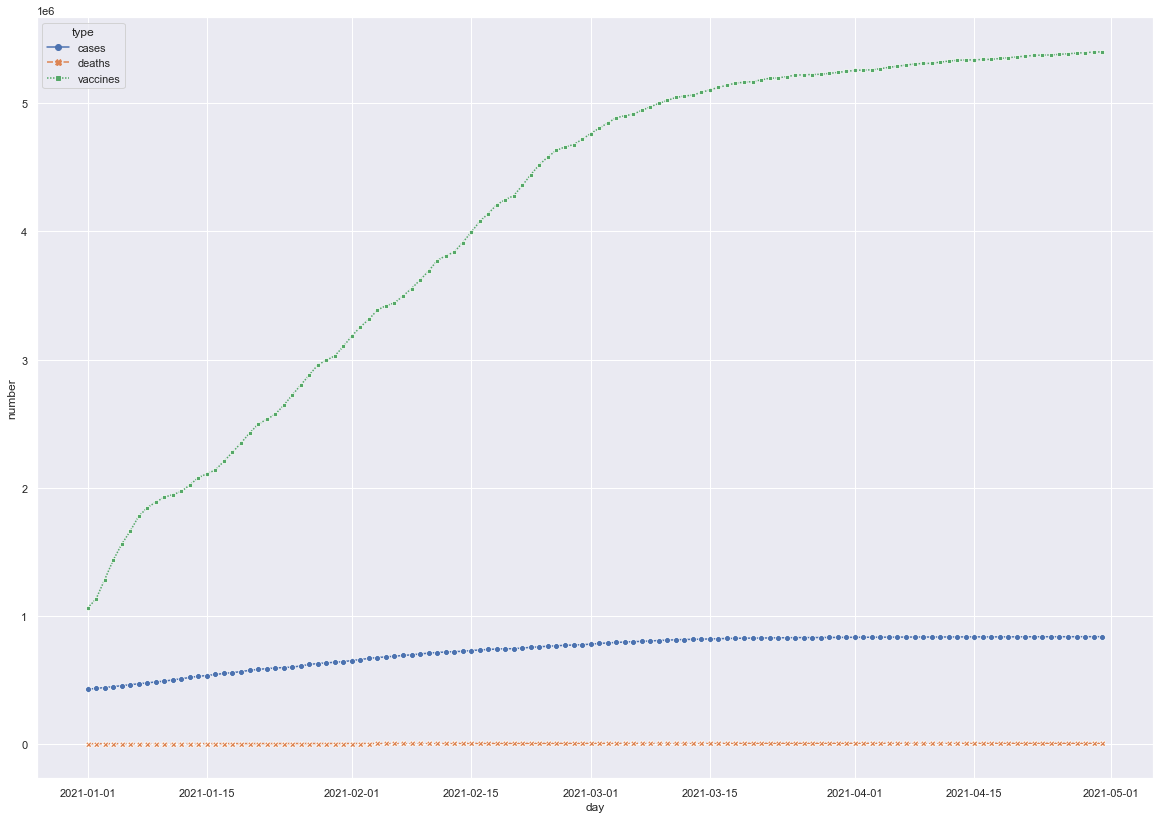

In [24]:
sns.set(rc={'figure.figsize':(20,14)})
sns.lineplot(x='day', y='number', hue='type', style='type', data=Israel_data, ci=None, markers=True)

We can observe that in Israel the number of vaccines (green) outperformed the number of cases (blue) and deaths (orange).

**United Kingdom**

We repeat the data extraction process for the United Kingdom, in the same time period.

In [25]:
UK_data = run_sql('''
SELECT *
FROM covid_data
WHERE country = 'GB' AND day >= '2021-01-01' AND day < '2021-05-01'
''')

UK_data['day'] = pd.to_datetime(UK_data['day'], format = '%Y-%m-%d')

UK_data

,country,day,number,type
0,GB,2021-01-01,2549693.0,cases
1,GB,2021-01-02,2607546.0,cases
2,GB,2021-01-03,2662703.0,cases
3,GB,2021-01-04,2721626.0,cases
4,GB,2021-01-05,2782713.0,cases
...,...,...,...,...
346,GB,2021-04-26,33843580.0,vaccines
347,GB,2021-04-27,33959908.0,vaccines
348,GB,2021-04-28,34094048.0,vaccines
349,GB,2021-04-29,34216616.0,vaccines


We plot the dataframe:

<AxesSubplot:xlabel='day', ylabel='number'>

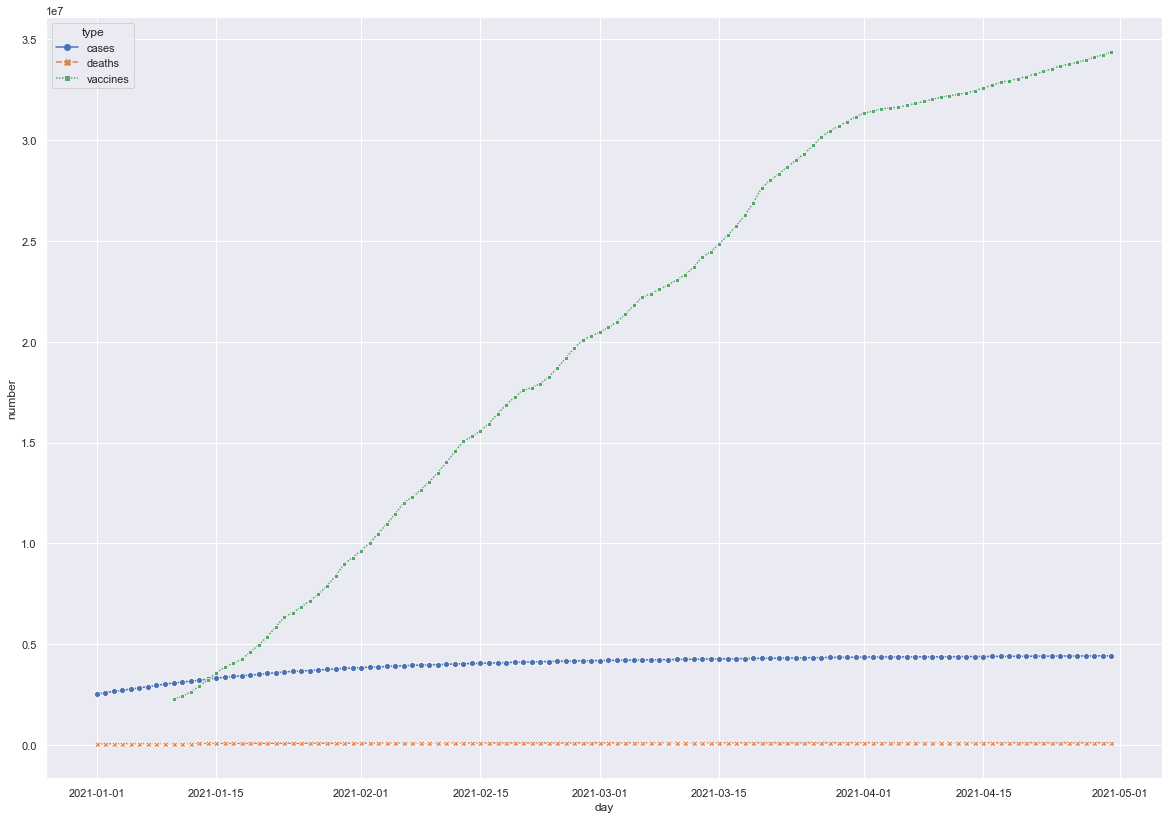

In [26]:
sns.set(rc={'figure.figsize':(20,14)})
sns.lineplot(x='day', y='number', hue='type', style='type', data=UK_data, ci=None, markers=True)

Like in Israel, the number of vaccines (green) outperformed the number of cases (blue) and deaths (orange) in the UK.

### 3.2.2. Relative vaccination rate

We aim to generate a plot comparing the YTD relative vaccination rate in France, Italy, and Spain. The vaccination rate is defined as the number of people vaccinated divided by the total population size. 

First, we create a new table:
    
**vaccination_rate_EU**(country, day, vax_rate)

We store a two-letters identifier for each country, the days, and the vaccination rate for each day and each country. Then, we insert the values.

In [27]:
run_sql('''
CREATE TABLE vaccination_rate_EU (
country VARCHAR(2),
day DATE,
vax_rate FLOAT
);
''')

In [28]:
run_sql('''
INSERT INTO vaccination_rate_EU
SELECT vaccines_record.country_code, vaccines_record.day, vaccines_record.people_vaccinated/country.population
FROM country, vaccines_record
WHERE vaccines_record.country_code = country.identifier
''')

We run a SQL query to extract the vaccination rate in the three countries we are interested in during our decided time. Then, we save the result in a dataframe, which we check.

In [29]:
vax_rate_EU = run_sql('''
SELECT *
FROM vaccination_rate_EU
WHERE (country = 'ES' OR country = 'FR' OR country = 'IT') AND day >= '2021-01-01' AND day < '2021-05-11'
''')

vax_rate_EU['day'] = pd.to_datetime(vax_rate_EU['day'], format = '%Y-%m-%d')

vax_rate_EU

,country,day,vax_rate
0,ES,2021-01-05,0.002980
1,ES,2021-01-07,0.004434
2,ES,2021-01-08,0.005945
3,ES,2021-01-11,0.008685
4,ES,2021-01-12,0.010439
...,...,...,...
342,IT,2021-05-06,0.263474
343,IT,2021-05-07,0.269206
344,IT,2021-05-08,0.274460
345,IT,2021-05-09,0.278608


We plot the dataframe:

<AxesSubplot:xlabel='day', ylabel='vax_rate'>

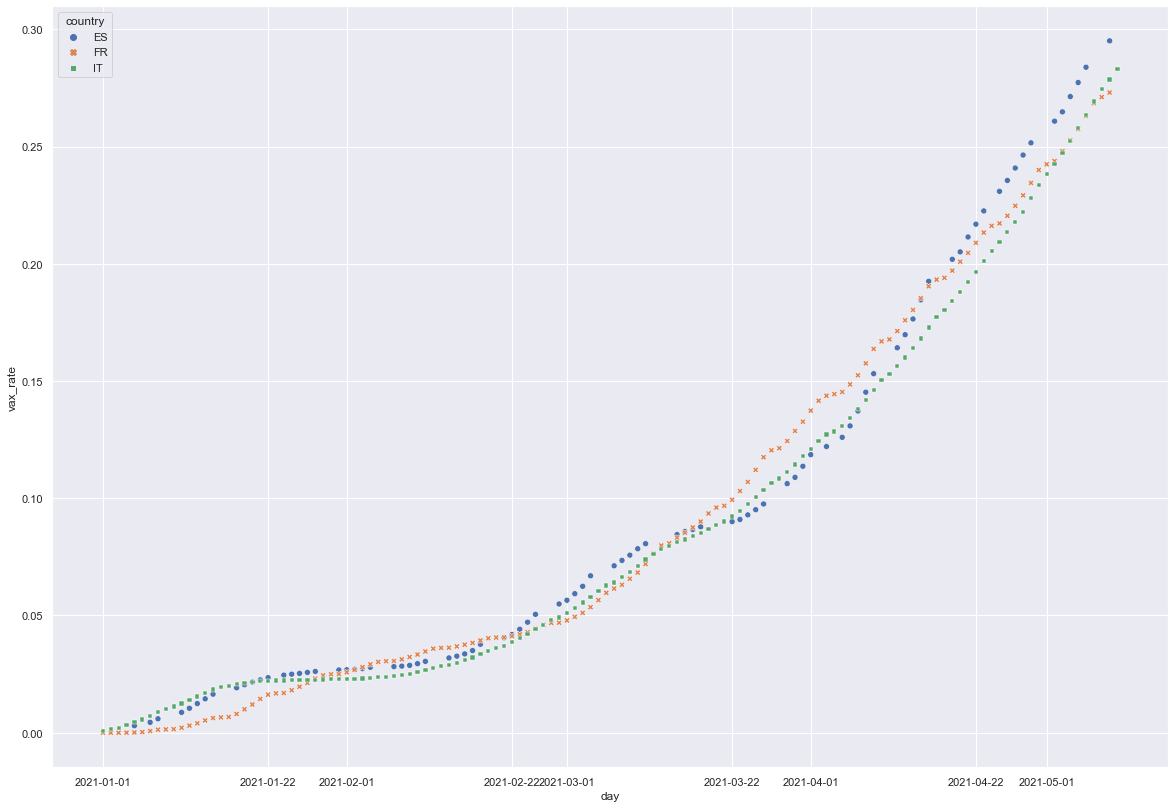

In [30]:
sns.set(rc={'figure.figsize':(20,14)})
sns.scatterplot(x="day", y="vax_rate", data=vax_rate_EU, hue='country', style='country')

The vaccination rate in France (orange), Italy (green), and Spain (blue) is positively correlated.

### 3.2.3. Daily vaccinations in Italy

We want to plot the distribution of daily vaccinations in Italy.

In [31]:
Italy_daily = run_sql('''
SELECT daily_vaccinations
FROM vaccines_record
WHERE country_code = 'IT'
''')

Italy_daily

,daily_vaccinations
0,1425.0
1,1217.0
2,2387.0
3,8161.0
4,8741.0
...,...
129,451105.0
130,452197.0
131,461898.0
132,462838.0


C:\Users\leona\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


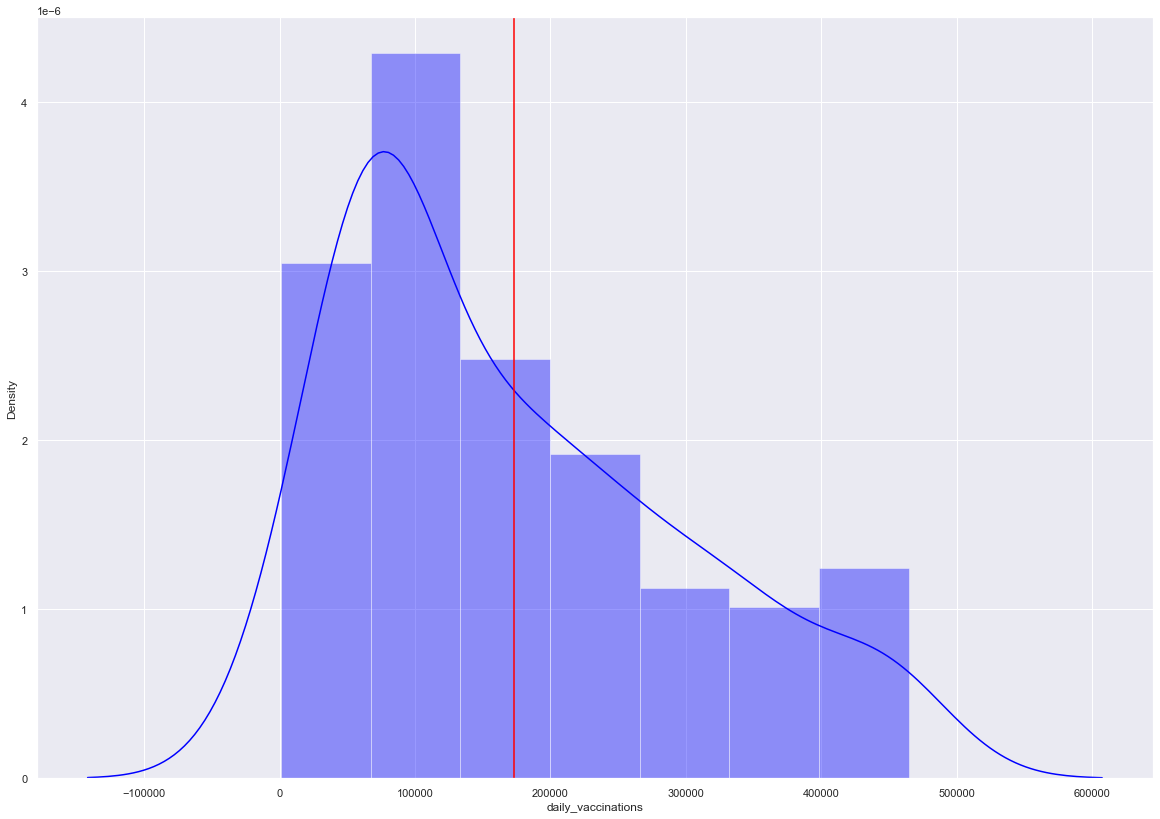

In [32]:
x = Italy_daily['daily_vaccinations']
sns.distplot(x, color='blue')
mean = Italy_daily['daily_vaccinations'].mean()
plt.axvline(x=mean, ymin=0, ymax=1, color='red') 

We can also obtain the mean through a SQL query.

In [33]:
run_sql('''
SELECT avg(daily_vaccinations) AS mean
FROM vaccines_record
WHERE country_code = 'IT'
''')

,mean
0,172793.298507


The average daily vaccination is about 172793.3

### 3.2.4. Vaccines_to_population

We represent on a folium map the countries having cumulative and up-to-date covid-19 cases < 100000.

First, we install and import folium. Then, we create a world map showing the countries.

In [34]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: ...working... done

# All requested packages already installed.



In [35]:
world_map = folium.Map(location=[0, 0], zoom_start=2)
world_map

In [36]:
world_df = run_sql('''
SELECT country.identifier, country.latitude AS la, country.longitude AS lo, covid_cases.confirmed
FROM country, covid_cases
WHERE country.identifier = covid_cases.country_code  AND covid_cases.confirmed < 100000 AND covid_cases.day IN (
SELECT max(A.day)
FROM covid_cases A
WHERE country.identifier = A.country_code)
''')

world_df

,identifier,la,lo,confirmed
0,AD,42.546245,1.601554,13429.0
1,AF,33.939110,67.709953,62063.0
2,AG,17.060816,-61.796428,1237.0
3,AO,-11.202692,17.873887,28875.0
4,AU,-25.274398,133.775136,29938.0
...,...,...,...,...
81,VU,-15.376706,166.959158,4.0
82,WS,-13.759029,-172.104629,3.0
83,YE,15.552727,48.516388,6485.0
84,ZM,-13.133897,27.849332,92112.0


In [37]:
millions = folium.map.FeatureGroup()

In [38]:
for lat, lng, in zip(world_df.la, world_df.lo):
    millions.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=1
        )
    )
    
world_map.add_child(millions)

## 4. CONCLUSION

By analyzing data, we discover exciting information about covid-19. For instance, we find out that the average number of daily vaccinations in Italy is about 172793.3. Also, we managed to plot a map with the countries with low covid-cases: it is interesting knowing that Australia is one of those countries, despite its extension. As a matter of fact, usually countries with low cases are small countries. Furthermore, we see how the cumulative vaccination number overperformed the cumulative cases and deaths number.